In [1]:
from __future__ import print_function

%matplotlib inline

import sys
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.contrib.framework.python.ops import variables

from collections import OrderedDict

import numpy as np
import scipy.misc
from input import *
from model import *
from train import *
import matplotlib.pyplot as plt
tf.reset_default_graph()

1.3.0


In [2]:
image_shape = (160,576)
iterator, filename = get_train_inputs(batch_size=100,
                                      repeat=True, 
                                      num_classes=2, 
                                      image_shape=image_shape)

In [3]:
_show = False
if _show:
    with tf.Session() as sess:
        sess.run(iterator.initializer, feed_dict={filename: ['data/kitti_segmentation.tfrecord']})
        next_element = iterator.get_next()
        i = 1
        while i < 10:
            i += 1
            print("*"*10)
            image, label = sess.run(next_element)
            print(image.shape, label.shape)
            plt.imshow(np.uint8(image))
            plt.imshow(label[:,:,0], cmap='jet', alpha=0.5)
            plt.show()

In [4]:
# record_iterator = tf.python_io.tf_record_iterator(path='data/kitti_segmentation.tfrecord')
# string_record = next(record_iterator)
# example = tf.train.Example()
# example.ParseFromString(string_record)

## Model

In [5]:
encoder = SlimModelEncoder(name="vgg_16", num_classes=2, is_training=True)
image, label = iterator.get_next()
restore_fn, end_points = encoder.build(image=image, image_shape=image_shape)

restore following variables: [<tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_1/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_2/biases:0' shape=(25

In [6]:
print(label)

Tensor("IteratorGetNext:1", shape=(160, 576, 2), dtype=int64)


In [7]:
end_points.keys()

odict_keys(['vgg_16/conv1/conv1_1', 'vgg_16/conv1/conv1_2', 'vgg_16/pool1', 'vgg_16/conv2/conv2_1', 'vgg_16/conv2/conv2_2', 'vgg_16/pool2', 'vgg_16/conv3/conv3_1', 'vgg_16/conv3/conv3_2', 'vgg_16/conv3/conv3_3', 'vgg_16/pool3', 'vgg_16/conv4/conv4_1', 'vgg_16/conv4/conv4_2', 'vgg_16/conv4/conv4_3', 'vgg_16/pool4', 'vgg_16/conv5/conv5_1', 'vgg_16/conv5/conv5_2', 'vgg_16/conv5/conv5_3', 'vgg_16/pool5', 'vgg_16/fc6', 'vgg_16/fc7', 'vgg_16/fc8'])

In [8]:
tf.get_collection(ops.GraphKeys.REGULARIZATION_LOSSES)

[<tf.Tensor 'vgg_16/conv1/conv1_1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv1/conv1_2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv2/conv2_1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv2/conv2_2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv3/conv3_1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv3/conv3_2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv3/conv3_3/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv4/conv4_1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv4/conv4_2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv4/conv4_3/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>,
 <tf.Tensor 'vgg_16/conv5/conv5_1/kernel

In [9]:
print(end_points['vgg_16/pool3'], 
    end_points['vgg_16/pool4'], 
    end_points['vgg_16/conv5/conv5_3'],
    end_points['vgg_16/fc7'],
    end_points['vgg_16/fc8'],sep='\n')

Tensor("vgg_16/pool3/MaxPool:0", shape=(1, 20, 72, 256), dtype=float32)
Tensor("vgg_16/pool4/MaxPool:0", shape=(1, 10, 36, 512), dtype=float32)
Tensor("vgg_16/conv5/conv5_3/Relu:0", shape=(1, 10, 36, 512), dtype=float32)
Tensor("vgg_16/fc7/Relu:0", shape=(1, 5, 18, 4096), dtype=float32)
Tensor("vgg_16/fc8/BiasAdd:0", shape=(1, 5, 18, 2), dtype=float32)


In [10]:
decoder = FCNDecoder(end_points, nb_classes=2, scope='decoder')

In [11]:
tensors_to_connect = OrderedDict()
tensors_to_connect["vgg_16/fc8"] = (2,2)
tensors_to_connect['vgg_16/pool4'] = (2,2)
tensors_to_connect['vgg_16/pool3'] = (8,8)

In [12]:
net = decoder.build(tensors_to_connect)

In [13]:
assert tuple(net.get_shape().as_list()[1:3]) == image_shape

In [14]:
tf.get_collection('trainable_variables')

[<tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_1/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>,
 <tf.Variable 'vgg_16/conv3/conv3_2/biases:0' shape=(256,) dtype=float32_

In [15]:
tf.get_collection('decoder_end_points')

[<tf.Tensor 'decoder/Conv/BiasAdd:0' shape=(1, 5, 18, 2) dtype=float32>,
 <tf.Tensor 'decoder/upsample_conv_0/BiasAdd:0' shape=(1, 10, 36, 2) dtype=float32>,
 <tf.Tensor 'decoder/Conv_1/BiasAdd:0' shape=(1, 10, 36, 2) dtype=float32>,
 <tf.Tensor 'decoder/upsample_conv_1/BiasAdd:0' shape=(1, 20, 72, 2) dtype=float32>,
 <tf.Tensor 'decoder/Conv_2/BiasAdd:0' shape=(1, 20, 72, 2) dtype=float32>,
 <tf.Tensor 'decoder/upsample_conv_2/BiasAdd:0' shape=(1, 160, 576, 2) dtype=float32>]

## Train

In [16]:
trainer = Trainer(nb_classes=2, optimizer=tf.train.AdamOptimizer, learning_rate=1e-4)

In [17]:
net

<tf.Tensor 'decoder/upsample_conv_2/BiasAdd:0' shape=(1, 160, 576, 2) dtype=float32>

In [18]:
trainer.build(predictions=net, labels=label)

pred shape (92160, 2), label shape (92160, 2)


In [19]:
trainer.train(iterator, 
              restore_fn=restore_fn, 
              number_of_steps=2500, 
              filename=['data/kitti_segmentation.tfrecord'])

INFO:tensorflow:Restoring parameters from model_checkpoints/vgg_16.ckpt
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/tf/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:global step 1: loss = 1.9657 (15.927 sec/step)
INFO:tensorflow:global step 2: loss = 1.7266 (8.195 sec/step)
INFO:tensorflow:global step 3: loss = 1.6171 (7.499 sec/step)
INFO:tensorflow:global step 4: loss = 1.5311 (7.877 sec/step)
INFO:tensorflow:global step 5: loss = 1.4173 (7.750 sec/step)
INFO:tensorflow:global step 6: loss = 1.4101 (7.558 sec/step)
INFO:tensorflow:global step 7: loss = 1.3737 (8.766 sec/step)
INFO:tensorflow:global step 8: loss = 1.3341 (7.441 sec/step)
INFO:tensorflow:global step 9: loss = 1.2972 (8.466 sec/step)
INFO:tensorflow:global step 10: loss = 1.2471 (7.676 sec/step)
INFO:tensorflow:global step 11: loss = 1.2205 (10.747 sec/step)
INFO:tensorflow:global step 12: lo

## Predict

restore following variables: [<tf.Variable 'vgg_16/conv1/conv1_1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_1/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'vgg_16/conv1/conv1_2/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_1/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_2/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>, <tf.Variable 'vgg_16/conv2/conv2_2/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_1/weights:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_1/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_2/weights:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'vgg_16/conv3/conv3_2/biases:0' shape=(25

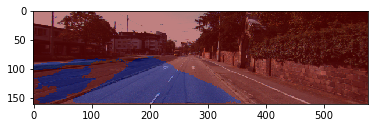

Tensor("Squeeze_1:0", shape=(160, 576, 2), dtype=float32)


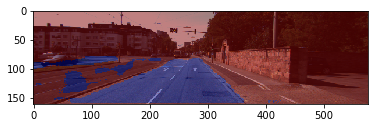

Tensor("Squeeze_2:0", shape=(160, 576, 2), dtype=float32)


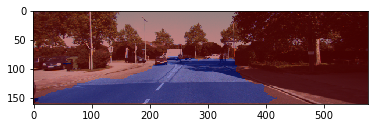

Tensor("Squeeze_3:0", shape=(160, 576, 2), dtype=float32)


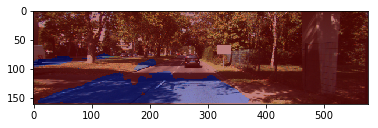

Tensor("Squeeze_4:0", shape=(160, 576, 2), dtype=float32)


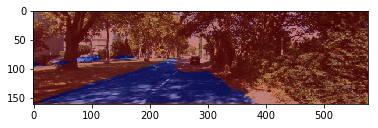

Tensor("Squeeze_5:0", shape=(160, 576, 2), dtype=float32)


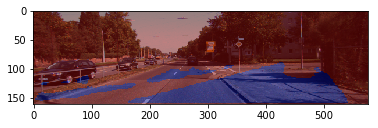

Tensor("Squeeze_6:0", shape=(160, 576, 2), dtype=float32)


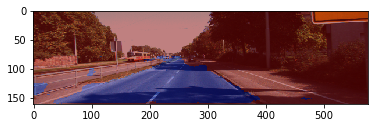

Tensor("Squeeze_7:0", shape=(160, 576, 2), dtype=float32)


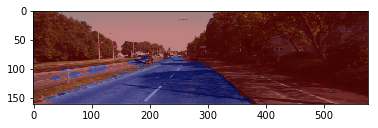

Tensor("Squeeze_8:0", shape=(160, 576, 2), dtype=float32)


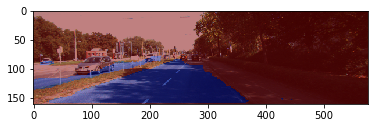

Tensor("Squeeze_9:0", shape=(160, 576, 2), dtype=float32)


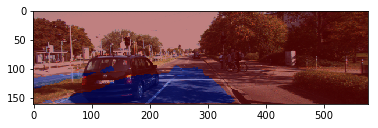

In [21]:
TRAIN_DIR = "model_checkpoints/"
with tf.Graph().as_default() as graph:
    image_shape = (160,576)
    iterator, filename = get_train_inputs(batch_size=1,
                                      repeat=False, 
                                      num_classes=2, 
                                      image_shape=image_shape)
    encoder = SlimModelEncoder(name="vgg_16", num_classes=2, is_training=False)
    image, label = iterator.get_next()
    assign_op, end_points = encoder.build(image=image, image_shape=image_shape)
    # tensors to connect and encoder
    decoder = FCNDecoder(end_points, nb_classes=2, scope='decoder')
    tensors_to_connect = OrderedDict()
    tensors_to_connect["vgg_16/fc8"] = (2,2)
    tensors_to_connect['vgg_16/pool4'] = (2,2)
    tensors_to_connect['vgg_16/pool3'] = (8,8)
    net = decoder.build(tensors_to_connect)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, os.path.join(TRAIN_DIR,"model.ckpt-2500"))
        input_tensor = graph.get_tensor_by_name('training_data/input:0')
        sess.run(iterator.initializer, feed_dict={input_tensor: ['data/kitti_segmentation.tfrecord']})
        i = 0
        while i < 10:
            i += 1
            # inference
            print(net)
            net = tf.squeeze(net)
            out = sess.run(net)
            img = sess.run(image)
            plt.imshow(np.uint8(img))
            _argmax = np.argmax(out,axis=2)
            plt.imshow(_argmax, cmap='jet', alpha=0.5)
            plt.show()

In [ ]:
_argmax = np.argmax(label,axis=2)
plt.imshow(_argmax)

In [ ]:
_argmax = np.argmax(out,axis=2)
plt.imshow(_argmax)